In [10]:
!pip install shap==0.46.0

## ========== Import Libraries ==========

In [5]:
# prompt: mount google

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# === Core Libraries ===
import numpy as np
import pandas as pd

# === PyTorch: Deep Learning ===
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    roc_auc_score,
    roc_curve,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
# === Sklearn: Preprocessing & Metrics ===
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    matthews_corrcoef
)
from sklearn.model_selection import train_test_split

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === SHAP for Explainability ===
import shap

# === (Optional) Warnings Suppression ===
import warnings
warnings.filterwarnings('ignore')


In [13]:
df = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/df_metabolites_.csv")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['TNBC_Subtype'])
X = df.drop(columns=['TNBC_Subtype']).values
feature_names = df.drop(columns=['TNBC_Subtype']).columns

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# -------------------------
# Transformer Model
# -------------------------
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim, num_heads, num_layers, dropout):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.input_layer(x).unsqueeze(1)
        x = self.transformer(x)
        x = x[:, 0, :]
        return self.classifier(x)

# Hyperparameters
input_dim = X.shape[1]
hidden_dim = 128
num_heads = 4
num_layers = 2
dropout = 0.1
num_classes = len(np.unique(y))
learning_rate = 0.0005
epochs = 100

model = TransformerModel(input_dim, num_classes, hidden_dim, num_heads, num_layers, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -------------------------
# Training Loop
# -------------------------
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    preds = outputs.argmax(dim=1)
    acc = (preds == y_train_tensor).float().mean().item()

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")





Epoch 0 - Loss: 1.4128, Accuracy: 0.3361
Epoch 10 - Loss: 0.5056, Accuracy: 0.8080
Epoch 20 - Loss: 0.4193, Accuracy: 0.8395
Epoch 30 - Loss: 0.3728, Accuracy: 0.8575
Epoch 40 - Loss: 0.3344, Accuracy: 0.8735
Epoch 50 - Loss: 0.3001, Accuracy: 0.8848
Epoch 60 - Loss: 0.2712, Accuracy: 0.8974
Epoch 70 - Loss: 0.2421, Accuracy: 0.9072
Epoch 80 - Loss: 0.2202, Accuracy: 0.9158
Epoch 90 - Loss: 0.1996, Accuracy: 0.9238
Epoch 99 - Loss: 0.1828, Accuracy: 0.9306


##===Save Models for Comparabilty and Web App======

In [14]:
torch.save(model.state_dict(), '/content/drive/MyDrive/SAVED_MODELS/DEEPLEARNING/FULL_METABOLITES/TRANSFORMER_M.pth')
print("Transformer model saved successfully!")

Transformer model saved successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Train Accuracy: 0.943905031892275
Test Accuracy: 0.8946995464852607

Macro Precision: 0.8937234282840433
Macro Recall: 0.8934115316526596
Macro F1 Score: 0.8934721501699382

Weighted Precision: 0.8948403927949408
Weighted Recall: 0.8946995464852607
Weighted F1 Score: 0.8946911236146455

ROC AUC Score (OvR, macro): 0.9869

Classification Report (Short Labels):
              precision    recall  f1-score   support

         BL1       0.90      0.87      0.89      1404
         BL2       0.88      0.90      0.89      1502
         LAR       0.90      0.90      0.90      2211
           M       0.89      0.90      0.90      1939

    accuracy                           0.89      7056
   macro avg       0.89      0.89      0.89      7056
weighted avg       0.89      0.89      0.89      7056



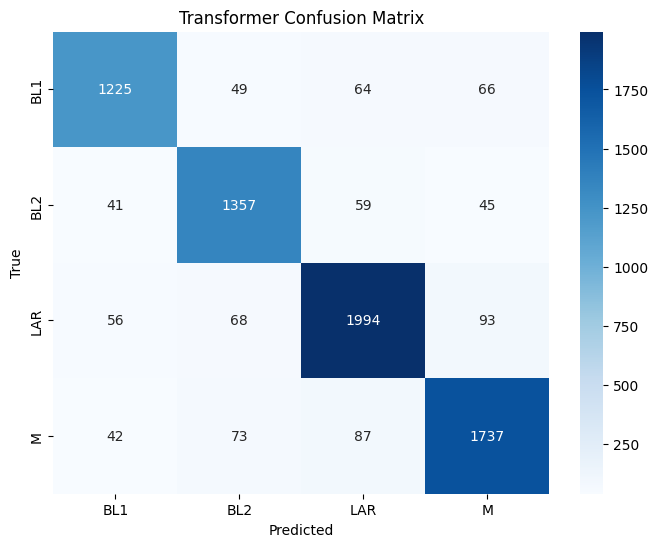


Matthews Correlation Coefficient (MCC): 0.858


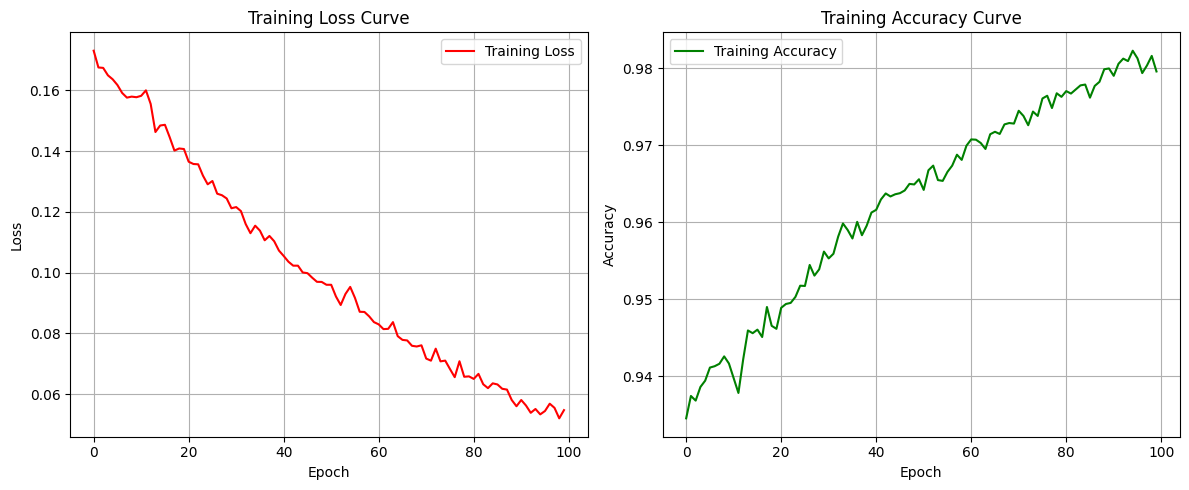

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, roc_auc_score, f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Define short labels
short_labels = ['BL1', 'BL2', 'LAR', 'M']  # Adjust if your subtypes are different

# Evaluate model
model.eval()
with torch.no_grad():
    train_logits = model(X_train_tensor)
    test_logits = model(X_test_tensor)

    train_preds = train_logits.argmax(dim=1).numpy()
    test_preds = test_logits.argmax(dim=1).numpy()

    train_probs = torch.softmax(train_logits, dim=1).numpy()
    test_probs = torch.softmax(test_logits, dim=1).numpy()

# Accuracy
print("\nTrain Accuracy:", accuracy_score(y_train_tensor.numpy(), train_preds))
print("Test Accuracy:", accuracy_score(y_test_tensor.numpy(), test_preds))

# F1, Precision, Recall
print("\nMacro Precision:", precision_score(y_test_tensor, test_preds, average='macro'))
print("Macro Recall:", recall_score(y_test_tensor, test_preds, average='macro'))
print("Macro F1 Score:", f1_score(y_test_tensor, test_preds, average='macro'))

print("\nWeighted Precision:", precision_score(y_test_tensor, test_preds, average='weighted'))
print("Weighted Recall:", recall_score(y_test_tensor, test_preds, average='weighted'))
print("Weighted F1 Score:", f1_score(y_test_tensor, test_preds, average='weighted'))

# ROC AUC
y_test_binarized = label_binarize(y_test_tensor.numpy(), classes=np.unique(y))
roc_auc = roc_auc_score(y_test_binarized, test_probs, average='macro', multi_class='ovr')
print("\nROC AUC Score (OvR, macro):", round(roc_auc, 4))

# Classification Report
print("\nClassification Report (Short Labels):")
print(classification_report(y_test_tensor, test_preds, target_names=short_labels))

# Confusion Matrix
cm = confusion_matrix(y_test_tensor, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=short_labels,
            yticklabels=short_labels)
plt.title("Transformer Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test_tensor, test_preds)
print("\nMatthews Correlation Coefficient (MCC):", round(mcc, 4))

# Plot Training Loss & Accuracy Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curve")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Sample a small background dataset for SHAP
background = X_train_tensor[:100]  # Example: Taking the first 100 samples from the training set

# Create the SHAP explainer
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test_tensor)

# Convert to NumPy for plotting
X_test_np = X_test_tensor.numpy()

# Transpose SHAP values for (classes, samples, features)
shap_values = np.transpose(shap_values, (2, 0, 1))  # Now shape = (4, 7056, 70) — updated to 70 features



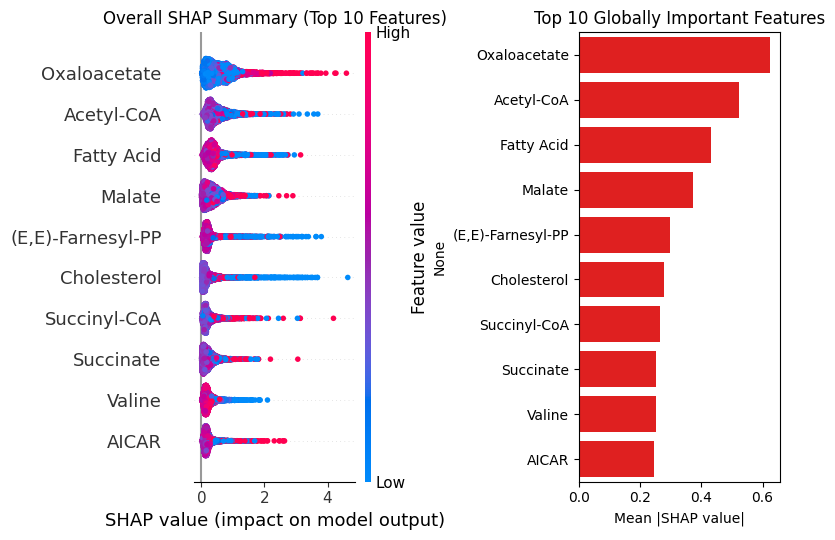

In [ ]:
# Compute the overall SHAP values for global feature importance
global_shap = np.mean(np.abs(shap_values), axis=0)  # shape: (samples, features)
global_mean_shap = np.mean(global_shap, axis=0)

# Get indices for top 10 global features (updated for 70 features)
top_indices_global = np.argsort(global_mean_shap)[-10:][::-1]
top_features_global = feature_names[top_indices_global]
top_importances_global = global_mean_shap[top_indices_global]

# Filter SHAP values and features for top 10 globally
shap_values_top_global = global_shap[:, top_indices_global]
X_test_top_global = X_test_np[:, top_indices_global]
top_feature_names_global = feature_names[top_indices_global]

# Create side-by-side plots for the overall SHAP summary and feature importance
plt.figure(figsize=(14, 6))

# Overall SHAP summary plot (left)
plt.subplot(1, 2, 1)
shap.summary_plot(shap_values_top_global, X_test_top_global, feature_names=top_feature_names_global, plot_type='dot', show=False)
plt.title("Overall SHAP Summary (Top 10 Features)")

# Global feature importance bar plot (right)
plt.subplot(1, 2, 2)
sns.barplot(x=top_importances_global, y=top_features_global, color='red')
plt.title("Top 10 Globally Important Features")
plt.xlabel("Mean |SHAP value|")

plt.tight_layout()
plt.show()


--- SHAP Summary for Subtype: Basal-like 1 (BL1) ---


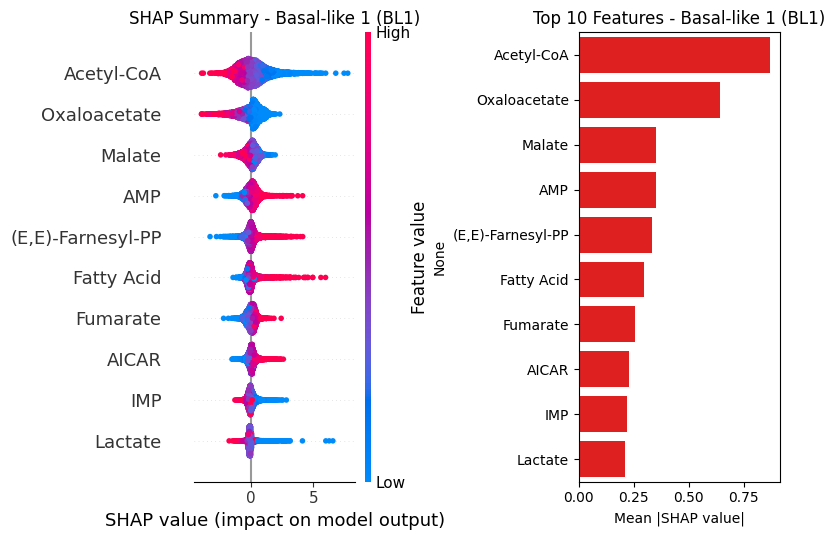


--- SHAP Summary for Subtype: Basal-like 2 (BL2) ---


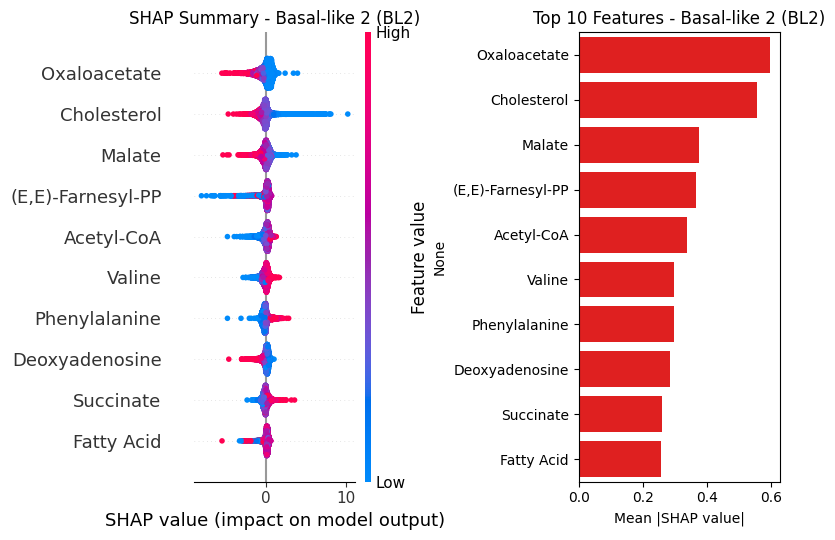


--- SHAP Summary for Subtype: Luminal Androgen Receptor (LAR) ---


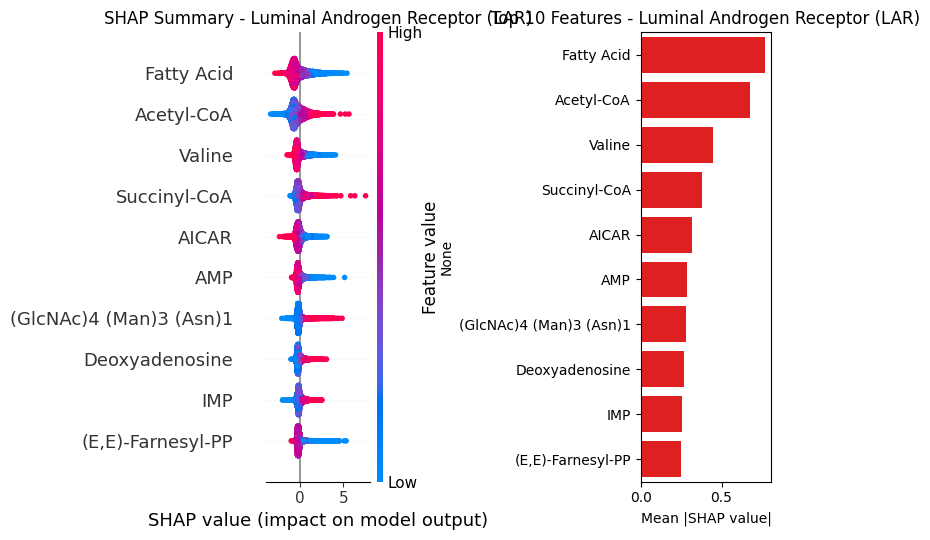


--- SHAP Summary for Subtype: Mesenchymal (M) ---


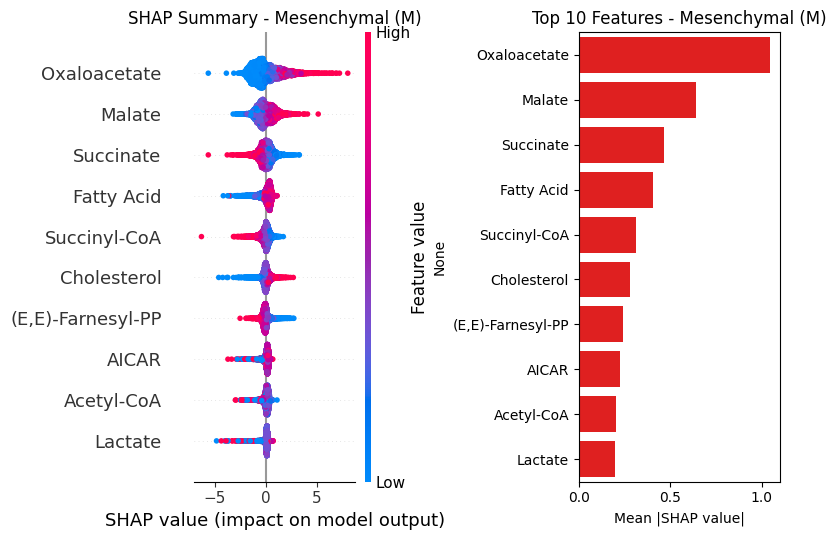

In [ ]:
# Now loop over each class/subtype for subtype-specific SHAP summary and feature importance
for i, subtype in enumerate(label_encoder.classes_):
    print(f"\n--- SHAP Summary for Subtype: {subtype} ---")

    # Compute the mean absolute SHAP value for ranking the features for each subtype
    mean_shap_subtype = np.mean(np.abs(shap_values[i]), axis=0)

    # Get indices for the top 10 features for this subtype (updated for 70 features)
    top_indices_subtype = np.argsort(mean_shap_subtype)[-10:][::-1]

    # Filter SHAP values and features for top 10 specific to the current subtype
    shap_values_top_subtype = shap_values[i][:, top_indices_subtype]
    X_test_top_subtype = X_test_np[:, top_indices_subtype]
    top_feature_names_subtype = feature_names[top_indices_subtype]

    plt.figure(figsize=(14, 6))

    # SHAP Summary Plot for top 10 features for the subtype (left)
    plt.subplot(1, 2, 1)
    shap.summary_plot(shap_values_top_subtype, X_test_top_subtype, feature_names=top_feature_names_subtype, plot_type='dot', show=False)
    plt.title(f"SHAP Summary - {subtype}")

    # Red bar plot for top 10 features (right)
    plt.subplot(1, 2, 2)
    top_importances_subtype = mean_shap_subtype[top_indices_subtype]
    sns.barplot(x=top_importances_subtype, y=top_feature_names_subtype, color='red')
    plt.title(f"Top 10 Features - {subtype}")
    plt.xlabel("Mean |SHAP value|")

    plt.tight_layout()
    plt.show()


###==================== USING UMAP DATAFRAME =====================

In [15]:
# === Core Libraries ===
import numpy as np
import pandas as pd

# === PyTorch: Deep Learning ===
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    roc_auc_score,
    roc_curve,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
# === Sklearn: Preprocessing & Metrics ===
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    matthews_corrcoef
)
from sklearn.model_selection import train_test_split

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === SHAP for Explainability ===
import shap

# === (Optional) Warnings Suppression ===
import warnings
warnings.filterwarnings('ignore')


In [16]:
df = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/metabolites_umap_training_.csv")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['TNBC_Subtype'])
X = df.drop(columns=['TNBC_Subtype']).values
feature_names = df.drop(columns=['TNBC_Subtype']).columns

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# -------------------------
# Transformer Model
# -------------------------
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim, num_heads, num_layers, dropout):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.input_layer(x).unsqueeze(1)
        x = self.transformer(x)
        x = x[:, 0, :]
        return self.classifier(x)

# Hyperparameters
input_dim = X.shape[1]
hidden_dim = 128
num_heads = 4
num_layers = 2
dropout = 0.1
num_classes = len(np.unique(y))
learning_rate = 0.0005
epochs = 100

model = TransformerModel(input_dim, num_classes, hidden_dim, num_heads, num_layers, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -------------------------
# Training Loop
# -------------------------
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    preds = outputs.argmax(dim=1)
    acc = (preds == y_train_tensor).float().mean().item()

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")





Epoch 0 - Loss: 1.8656, Accuracy: 0.0702
Epoch 10 - Loss: 0.1117, Accuracy: 0.9676
Epoch 20 - Loss: 0.0709, Accuracy: 0.9785
Epoch 30 - Loss: 0.0542, Accuracy: 0.9834
Epoch 40 - Loss: 0.0448, Accuracy: 0.9865
Epoch 50 - Loss: 0.0391, Accuracy: 0.9874
Epoch 60 - Loss: 0.0345, Accuracy: 0.9890
Epoch 70 - Loss: 0.0302, Accuracy: 0.9901
Epoch 80 - Loss: 0.0288, Accuracy: 0.9897
Epoch 90 - Loss: 0.0265, Accuracy: 0.9912
Epoch 99 - Loss: 0.0240, Accuracy: 0.9914


##===Save Models for Comparabilty and Web App======

In [17]:
torch.save(model.state_dict(), '/content/drive/MyDrive/SAVED_MODELS/DEEPLEARNING/UMAP/TRANSFORMER_M.pth')
print("Transformer model saved successfully!")

Transformer model saved successfully!



Train Accuracy: 0.9960666194188519
Test Accuracy: 0.9927721088435374

Macro Precision: 0.9922742317142133
Macro Recall: 0.9930465154798612
Macro F1 Score: 0.992640257998194

Weighted Precision: 0.992815204741957
Weighted Recall: 0.9927721088435374
Weighted F1 Score: 0.9927735324004461

ROC AUC Score (OvR, macro): 1.0

Classification Report (Short Labels):
              precision    recall  f1-score   support

         BL1       0.99      0.99      0.99      1404
         BL2       0.99      0.99      0.99      1939
         LAR       0.99      1.00      0.99      1502
           M       1.00      0.99      0.99      2211

    accuracy                           0.99      7056
   macro avg       0.99      0.99      0.99      7056
weighted avg       0.99      0.99      0.99      7056



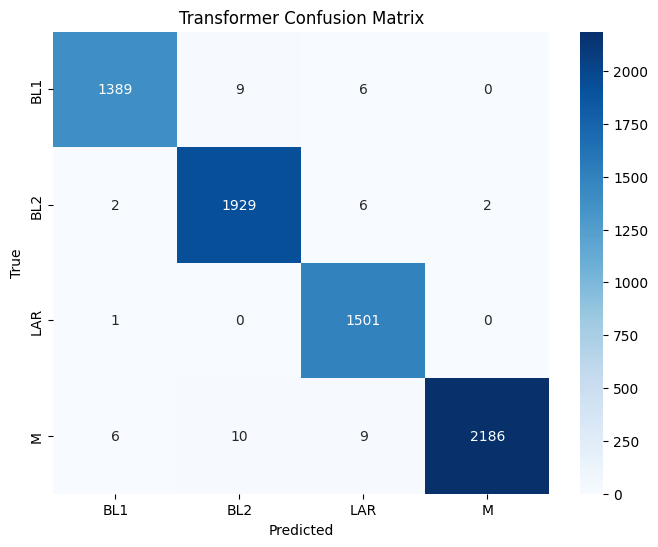


Matthews Correlation Coefficient (MCC): 0.9903


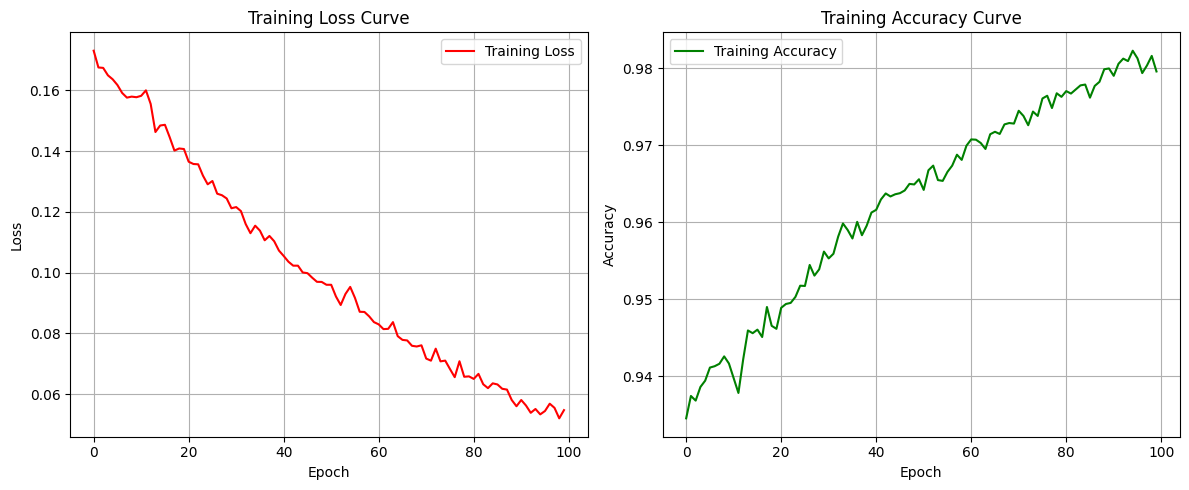

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, roc_auc_score, f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Define short labels
short_labels = ['BL1', 'BL2', 'LAR', 'M']  # Adjust if your subtypes are different

# Evaluate model
model.eval()
with torch.no_grad():
    train_logits = model(X_train_tensor)
    test_logits = model(X_test_tensor)

    train_preds = train_logits.argmax(dim=1).numpy()
    test_preds = test_logits.argmax(dim=1).numpy()

    train_probs = torch.softmax(train_logits, dim=1).numpy()
    test_probs = torch.softmax(test_logits, dim=1).numpy()

# Accuracy
print("\nTrain Accuracy:", accuracy_score(y_train_tensor.numpy(), train_preds))
print("Test Accuracy:", accuracy_score(y_test_tensor.numpy(), test_preds))

# F1, Precision, Recall
print("\nMacro Precision:", precision_score(y_test_tensor, test_preds, average='macro'))
print("Macro Recall:", recall_score(y_test_tensor, test_preds, average='macro'))
print("Macro F1 Score:", f1_score(y_test_tensor, test_preds, average='macro'))

print("\nWeighted Precision:", precision_score(y_test_tensor, test_preds, average='weighted'))
print("Weighted Recall:", recall_score(y_test_tensor, test_preds, average='weighted'))
print("Weighted F1 Score:", f1_score(y_test_tensor, test_preds, average='weighted'))

# ROC AUC
y_test_binarized = label_binarize(y_test_tensor.numpy(), classes=np.unique(y))
roc_auc = roc_auc_score(y_test_binarized, test_probs, average='macro', multi_class='ovr')
print("\nROC AUC Score (OvR, macro):", round(roc_auc, 4))

# Classification Report
print("\nClassification Report (Short Labels):")
print(classification_report(y_test_tensor, test_preds, target_names=short_labels))

# Confusion Matrix
cm = confusion_matrix(y_test_tensor, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=short_labels,
            yticklabels=short_labels)
plt.title("Transformer Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test_tensor, test_preds)
print("\nMatthews Correlation Coefficient (MCC):", round(mcc, 4))

# Plot Training Loss & Accuracy Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curve")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
